# Project 1: End-to-End Pipeline to Classify News Articles

## Question 1

### 1.1 Overview How many rows (samples) and columns (features) are present in the dataset?

In [3]:
import pandas as pd

df = pd.read_csv('Project1-ClassificationDataset.csv')

num_rows, num_cols = df.shape

print(f"Number of rows (samples): {num_rows}")
print(f"Number of cols (features): {num_cols}")

Number of rows (samples): 3476
Number of cols (features): 8


### 1.2 Histograms

#### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis

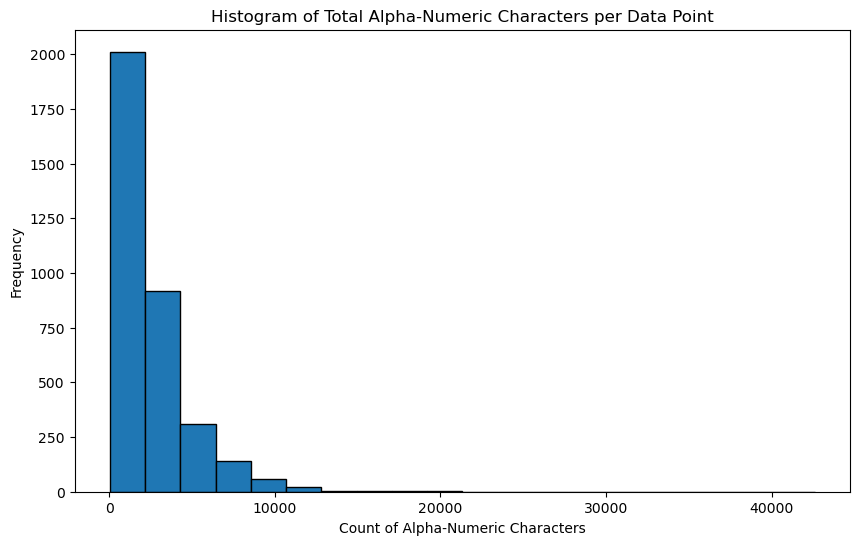

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
file_path = 'Project1-ClassificationDataset.csv'
df = pd.read_csv(file_path)

# (a) Histogram for the total number of alpha-numeric characters per data point
df['Total_AlphaNumeric_Count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))
plt.figure(figsize=(10, 6))
plt.hist(df['Total_AlphaNumeric_Count'], bins=20, edgecolor='black')
plt.title('Histogram of Total Alpha-Numeric Characters per Data Point')
plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.show()

#### (b) The column leaf label – class on the x-axis

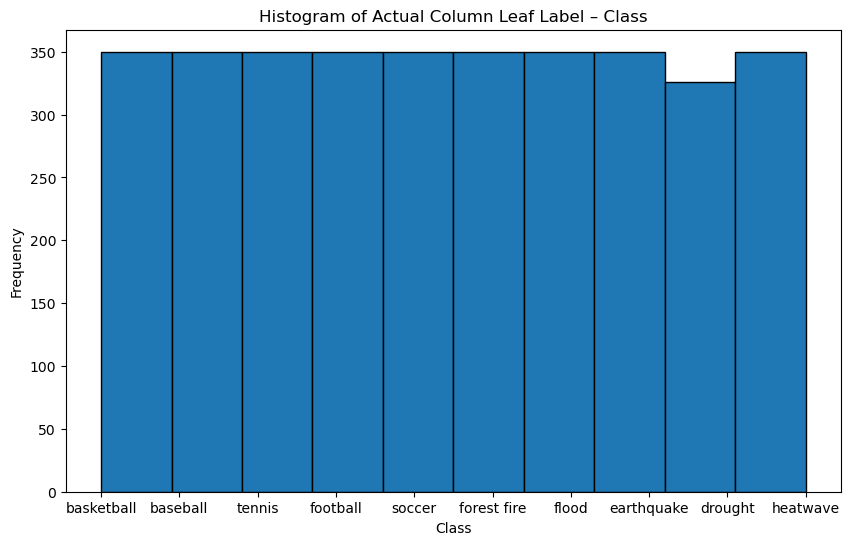

In [5]:
# (b) Histogram for the actual column leaf label – class
leaf_label_column = 'leaf_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[leaf_label_column], bins=df[leaf_label_column].nunique(), edgecolor='black')
plt.title('Histogram of Actual Column Leaf Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


#### (c) The column root label – class on the x-axis.

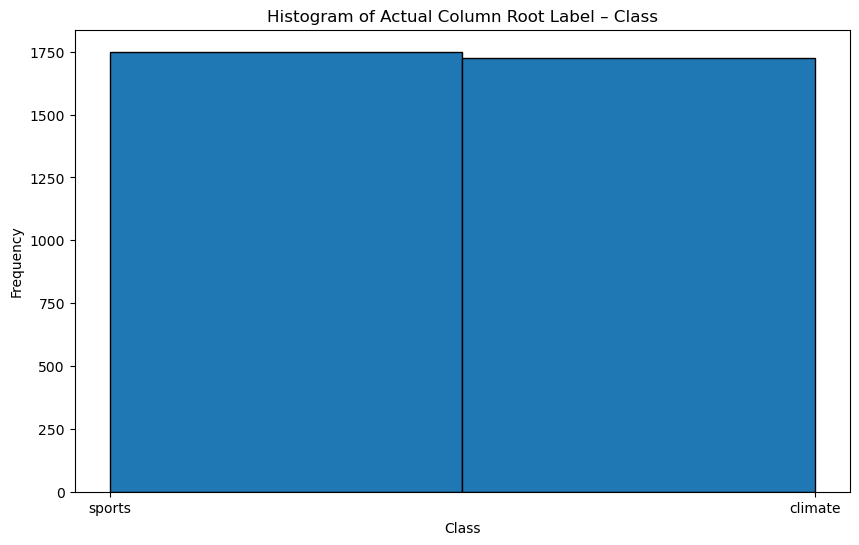

In [6]:
# (c) Histogram for the actual column root label – class
root_label_column = 'root_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[root_label_column], bins=df[root_label_column].nunique(), edgecolor='black')
plt.title('Histogram of Actual Column Root Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### 1.3 Interpret Plots: Provide qualitative interpretations of the histograms.

** incomplete **

a - Histogram of Alpha Numeric Characters per Data Point
- Histogram reveals the distribution of the total number of alpha-numeric characters in the 'full_text' feature for each data point


b - Histogram of Leaf Label Class
- b


c - Histogram of Root Label Class
- c

In [7]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

## QUESTION 2

### 2.1 Report the number of training and testing samples.

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

num_training_samples = len(train)
num_testing_samples = len(test)

print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3